# Demand Forecasting

This project aims to perform time series analysis based on 5 years of sales data for a company operating in the retail sector. The goal is to forecast future demand for 50 different stores and 10 different products. This analysis will assist the company in optimizing inventory management, stock replenishment, and demand forecasting processes.

This project is a kaggle competition and you can find out more information from here: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=sample_submission.csv

## Import libraries and read datasets

In [ ]:
# Imports
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_column', None)

In [ ]:
# Read train and test data
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
sample_sub = pd.read_csv('sample_submission.csv')

In [ ]:
# Check the train dataset
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
# Check the test dataset
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


**Important Note:** If you check the date period of test data, you can see that the period of data is only for 3 months and we will make forecasting for 3 months.

In [ ]:
# Check the submission format
sample_sub.head() # it is a submission format that kaggle waiting from us

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [ ]:
# Check the the length of train and test data
len(train), len(test)

(913000, 45000)

In [ ]:
# Merge train and test dataset as df
df = pd.concat([train, test])
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


## Discover the data

In [ ]:
# Get the min and max date
print(f"Minumum date in the data: {df['date'].min()}")
print(f"Maximum date in the data: {df['date'].max()}")

Minumum date in the data: 2013-01-01 00:00:00
Maximum date in the data: 2018-03-31 00:00:00


In [ ]:
# How many samples we have?
print(f'Total data: {len(df)}')

Total data: 958000


In [ ]:
# Info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [ ]:
# Check the missing values
df.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

There is no `id` column in the train dataset because we will not make predictions on the train data. Kaggle is waiting predictions on the test dataset and submit our predictions (sales) with id column. That's why we don't need to `id` column in the train data and `sales` in the test data. In conclusion, there is no missing value in the dataframe.

In [ ]:
# How many unique store we have?
df['store'].nunique()

10

In [ ]:
# How many unique item we have?
df['item'].nunique()

50

In [ ]:
# How many item we have each store?
df.groupby('store')['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
# Get the descriptive statistics of sales based on each store and each item
df.groupby(['store', 'item']).agg({'sales': ['sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                          
                 sum       mean median        std   min    max
store item                                                    
1     1      36468.0  19.971522   19.0   6.741022   4.0   50.0
      2      97050.0  53.148959   52.0  15.005779  13.0  115.0
      3      60638.0  33.208105   33.0  10.072529   8.0   70.0
      4      36440.0  19.956188   20.0   6.640618   4.0   43.0
      5      30335.0  16.612815   16.0   5.672102   3.0   37.0
...              ...        ...    ...        ...   ...    ...
10    46    120601.0  66.046550   65.0  18.114991  23.0  125.0
      47     45204.0  24.755750   24.0   7.924820   6.0   56.0
      48    105570.0  57.814896   57.0  15.898538  21.0  120.0
      49     60317.0  33.032311   32.0  10.091610   6.0   69.0
      50    135192.0  74.037240   73.0  19.937566  24.0  150.0

[500 rows x 6 columns]

In [ ]:
# Get the describe of numeric values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,958000.0,5.500000,2.872283,1.0,3.00,5.5,8.00,10.0
item,958000.0,25.500000,14.430877,1.0,13.00,25.5,38.00,50.0
sales,913000.0,52.250287,28.801144,0.0,30.00,47.0,70.00,231.0
id,45000.0,22499.500000,12990.525394,0.0,11249.75,22499.5,33749.25,44999.0


## Feature Engineering

In [ ]:
# Create a function for getting more information from date column
def create_date_features(dataframe):
  dataframe['month'] = dataframe.date.dt.month
  dataframe['day_of_month'] = dataframe.date.dt.day
  dataframe['day_of_year'] = dataframe.date.dt.day_of_year
  dataframe['week_of_year'] = dataframe.date.dt.weekofyear
  dataframe['day_of_week'] = dataframe.date.dt.day_of_week
  dataframe['year'] = dataframe.date.dt.year
  dataframe['is_weekend'] = dataframe.date.dt.weekday // 4
  dataframe['is_month_start'] = dataframe.date.dt.is_month_start.astype(int)
  dataframe['is_month_end'] = dataframe.date.dt.is_month_end.astype(int)

  return dataframe

In [ ]:
# Create a new dataframe with using date function
df = create_date_features(df)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [ ]:
# Get the descriptive statistics of sales based on each store, each item and each month
df.groupby(['store', 'item', 'month']).agg({'sales': ['sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                          
                      sum       mean median        std   min    max
store item month                                                   
1     1    1       2125.0  13.709677   13.0   4.397413   5.0   29.0
           2       2063.0  14.631206   14.0   4.668146   5.0   29.0
           3       2728.0  17.600000   17.0   4.545013   4.0   31.0
           4       3118.0  20.786667   20.0   4.894301   9.0   36.0
           5       3448.0  22.245161   22.0   6.564705   7.0   39.0
...                   ...        ...    ...        ...   ...    ...
10    50   8      13108.0  84.567742   85.0  15.676527  48.0  124.0
           9      11831.0  78.873333   79.0  15.207423  39.0  114.0
           10     11322.0  73.045161   72.0  14.209171  39.0  113.0
           11     11549.0  76.993333   77.0  16.253651  43.0  123.0
           12      8724.0  56.283871   56.0  11.782529  29.0   88.0

[6000 rows x 6 columns]

### Lag/Shifted Features

In time series analysis, lag and shifted features are important concepts that help capture the temporal dependencies and patterns within a sequence of data points. These concepts are often used in the context of autoregressive models, moving average models, and other time series forecasting techniques. Let's
break down what lag and shifted features mean:


* In the context of time series analysis, a lag refers to the time delay or offset between two observations in a time series.
* The term "lag" is typically denoted as "L" followed by a number, such as "L1" for a lag of one time period, "L2" for a lag of two time periods, and so on.
* A lag of "L1" represents the relationship between a data point at time t and the data point at time t-1.
* Lags are used to capture the autocorrelation or self-dependency within a time series, helping to identify patterns and trends.
* By shifting the time series data, you create new features that represent the values of the series at previous or future time points.
* For example, if you have a time series of daily stock prices and you create shifted features with lags of 1, 2, and 3 days, you would have columns representing the stock prices from the previous three days.

We should sort our data based on store, item and date before creating lag/shifted features. So let's sort values..


In [ ]:
# Sort dataframe based on store, itemi date
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [ ]:
# Check dataframe
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [ ]:
# Lets try to understand of these features using first 10 samples
pd.DataFrame({'sales': df['sales'].values[0:10],
              'lag_1': df['sales'].shift(1).values[0:10],
              'lag_2': df['sales'].shift(2).values[0:10],
              'lag_3': df['sales'].shift(3).values[0:10],
              'lag_4': df['sales'].shift(4).values[0:10],
              'lag_5': df['sales'].shift(5).values[0:10]})

,sales,lag_1,lag_2,lag_3,lag_4,lag_5
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN,NaN
4,10.0,13.0,14.0,11.0,13.0,NaN
5,12.0,10.0,13.0,14.0,11.0,13.0
6,10.0,12.0,10.0,13.0,14.0,11.0
7,9.0,10.0,12.0,10.0,13.0,14.0
8,12.0,9.0,10.0,12.0,10.0,13.0
9,9.0,12.0,9.0,10.0,12.0,10.0


As you can see the from above table, "lag_1" represent the one previous sales value while 'lag_2' two previous sales value and so on.

We will also add some random noise to the lag features for preventing the overfitting. Let's create the random noise function.

In [ ]:
# Random noise function
def add_random_noise(dataframe):
  return np.random.normal(scale=1.6, size=(len(dataframe),))

scale=1.6 means that the random numbers will be generated from a normal distribution with a standard deviation of 1.6.

The size parameter determines the shape or dimensions of the output array of random numbers.

In [ ]:
# Create the lag/shifted function
def lag_feautes(dataframe, lags):
  for lag in lags:
    dataframe['sales_lag_' + str(lag)] = dataframe.groupby(['store', 'item'])['sales'].transform(
        lambda x: x.shift(lag)) + add_random_noise(dataframe)

  return dataframe

In [ ]:
# Define lags
lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728] # we start with 91 because we want to make  predictions for 3 months

# Add lags to the our dataframe
df = lag_feautes(df, lags=lags)

In [ ]:
# Check the the dataframe and lags
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,40.495767,53.484093,66.827124,66.291003,69.238728,80.709607,79.396554,60.253190,97.192582,73.340379
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,63.447832,52.321891,68.860432,61.351604,77.265333,81.957084,78.372069,72.750173,77.039703,71.511464
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,58.270958,60.781795,71.806223,64.628891,74.831997,84.897609,83.477006,70.336768,99.720590,77.477688
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,69.560428,73.843263,70.907095,62.173659,64.499108,77.662270,93.457650,70.395815,77.703459,83.783133


### Moving Average Features

Basically, you specify a window size or interval, which determines how many data points are included in each average calculation. For example, a 7-day rolling moving average would use a window size of 7, meaning it calculates the average of the previous 7 data points at each time step.

In [ ]:
# Create moving average features using first 10 samples
pd.DataFrame({'sales': df['sales'].values[0:10],
              'rolling_2': df['sales'].shift(1).rolling(2).mean().values[0:10],
              'rolling_3': df['sales'].shift(1).rolling(3).mean().values[0:10],
              'rolling_4': df['sales'].shift(1).rolling(4).mean().values[0:10],
              'rolling_5': df['sales'].shift(1).rolling(5).mean().values[0:10]})

,sales,rolling_2,rolling_3,rolling_4,rolling_5
0,13.0,NaN,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN,NaN
3,13.0,12.5,12.666667,NaN,NaN
4,10.0,13.5,12.666667,12.75,NaN
5,12.0,11.5,12.333333,12.00,12.2
6,10.0,11.0,11.666667,12.25,12.0
7,9.0,11.0,10.666667,11.25,11.8
8,12.0,9.5,10.333333,10.25,10.8
9,9.0,10.5,10.333333,10.75,10.6


We used `shift(1)` because we want to use only previous values for creating new features. Otherwise current values will be add the calculations.

In [ ]:
# Let's create moving average features
def rol_mean_features(dataframe, windows):
  for window in windows:
    dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(['store', 'item'])['sales']. \
    transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type='triang').mean()) + add_random_noise(dataframe)
  return dataframe

In [ ]:
# Apply the moving average function to our dataframe
df = rol_mean_features(df, [365, 576])

In [ ]:
# Check the dataframe after applying rolling moving average
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_576
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,40.495767,53.484093,66.827124,66.291003,69.238728,80.709607,79.396554,60.253190,97.192582,73.340379,86.944189,82.664061
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,63.447832,52.321891,68.860432,61.351604,77.265333,81.957084,78.372069,72.750173,77.039703,71.511464,85.247356,84.847902
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,58.270958,60.781795,71.806223,64.628891,74.831997,84.897609,83.477006,70.336768,99.720590,77.477688,89.028080,86.657079
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,69.560428,73.843263,70.907095,62.173659,64.499108,77.662270,93.457650,70.395815,77.703459,83.783133,87.750697,86.260159


### Exponentially Weighted Features

Exponentially Weighted Features (EWF) is a technique used in time series analysis and forecasting to give more weight to recent data points while progressively decreasing the weight of older data points. It is a method for creating a weighted moving average of a time series, where the weights decrease exponentially as you move further back in time. This approach is particularly useful when you want to capture trends and patterns in the data that may change over time.

Let's create exponentially weighted features using first 10 samples.

In [ ]:
# Try exponential weighted features using first 10 samples
pd.DataFrame({
    'sales': df['sales'].values[:10],
    'roll2': df['sales'].shift(1).rolling(window=2).mean().values[:10],
    'ewm099': df['sales'].shift(1).ewm(alpha=0.99).mean().values[:10],
    'ewm095': df['sales'].shift(1).ewm(alpha=0.95).mean().values[:10],
    'ewm07': df['sales'].shift(1).ewm(alpha=0.7).mean().values[:10],
    'ewm02': df['sales'].shift(1).ewm(alpha=0.2).mean().values[:10]
})

,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.888889
3,13.0,12.5,13.970201,13.855107,13.287770,12.754098
4,10.0,13.5,13.009702,13.042750,13.084686,12.837398
5,12.0,11.5,10.030097,10.152137,10.920146,11.993337
6,10.0,11.0,11.980301,11.907607,11.676595,11.995143
7,9.0,11.0,10.019803,10.095380,10.502722,11.490225
8,12.0,9.5,9.010198,9.054769,9.450748,10.891777
9,9.0,10.5,11.970102,11.852738,11.235259,11.147782


In [ ]:
# Create a function for creating exponential weighted features
def ewm_features(dataframe, alphas, lags):
  for alpha in alphas:
    for lag in lags:
      dataframe['sales_ewm_alpha_' + str(alpha).replace('.', '') + '_lag_' + str(lag)] = \
      dataframe.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
  return dataframe

In [ ]:
# Creating alphas and lags
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [ ]:
# Applying exponential weighted features to our dataframe
df = ewm_features(df, alphas=alphas, lags=lags)

In [ ]:
# Check the dataframe
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_576,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,40.495767,53.484093,66.827124,66.291003,69.238728,80.709607,79.396554,60.253190,97.192582,73.340379,86.944189,82.664061,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,63.447832,52.321891,68.860432,61.351604,77.265333,81.957084,78.372069,72.750173,77.039703,71.511464,85.247356,84.847902,61.928

### One-Hot Encoding

In [ ]:
# One hot encoding
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [ ]:
df.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_weekend,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_576,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
# Check the how many features we have?
len(df.columns)

146

### Log of Dependent Variables

In this section, we will standardize the target variable because of faster training.  

In [ ]:
# Check the max and min sales value before log
min(df['sales']), max(df['sales'])

(0.0, 231.0)

In [ ]:
# Log of dependent variable
df['sales'] = np.log1p(df['sales'].values)

In [ ]:
# Check the max and min sales value after log
min(df['sales']), max(df['sales'])

(0.0, 5.44673737166631)

## Model

### Evaluation metrics: SMAPE

SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

More info about MAPE, SMAPE: https://medium.com/@vinitkothari.24/time-series-evaluation-metrics-mape-vs-wmape-vs-smape-which-one-to-use-why-and-when-part1-32d3852b4779

In [ ]:
# Define the smape function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# LightGBM smape function
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

### Time Based Validation Sets

We have train and test datasets but we dont have any validation set and we will create it from the train data. Let's do that

In [ ]:
# Creating train and validation dataset
train = df[df['date'] < '2017-01-01']
val = df[(df['date'] >= '2017-01-01') & (df['date'] <= '2017-03-31')]

In [ ]:
val

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_weekend,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_576,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1461,2017-01-01,2.995732,NaN,1,1,52,2017,1,1,0,24.640688,27.242586,28.330789,26.314453,25.423973,30.388487,36.481346,12.949121,29.248201,12.295192,23.541106,20.427540,25.945616,26.945124,26.600120,24.052691,30.392182,24.746346,13.392104,30.474469,14.106506,25.884810,26.880977,26.200950,24.111103,29.867830,24.490565,13.766633,30.895524,14.222089,25.755581,26.727186,25.408003,24.243376,29.066596,24.001580,14.449431,31.560936,14.457248,25.626387,26.540456,24.631135,24.388848,28.589323,23.584817,15.014059,31.960188,14.659810,25.336195,26.033001,23.224180,24.695000,28.493284,23.083219,15.615928,31.842915,14.803870,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1462,2017-01-02,2.772589,NaN,2,2,1,2017,0,0,0,19.382503,13.805834,17.500494,27.059887,34.082049,12.045770,17.701082,15.204997,20.194349,14.582518,24.786753,20.761706,20.297281,17.497256,19.380006,24.002635,22.419609,18.337317,12.069605,20.523723,14.005325,20.588481,17.988098,19.720095,24.011110,22.786783,18.649056,12.176663,21.089552,14.022209,21.151116,18.945437,20.281601,24.048675,23.413319,19.200316,12.489886,22.312187,14.091450,21.687916,19.862137,20.689341,24.116654,23.976797,19.675445,12.904218,23.588056,14.197943,22.668098,21.516501,21.112090,24.347500,25.246642,20.541610,13.807964,25.921458,14.401935,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1463,2017-01-03,2.397895,NaN,3,3,1,2017,0,0,0,28.158090,17.668397,19.107720,21.671899,28.764899,15.809528,28.301965,11.582780,23.344556,8.983243,23.557874,19.941355,27.614864,17.974863,22.819000,24.000132,32.470980,22.766866,12.003480,23.826186,9.250266,27.258848,17.998810,22.672010,24.001111

### Define features and label

In [ ]:
# Get the features name as list
cols = [col for col in train.columns if col not in ['date', 'id', 'sales', 'year']]
cols

['day_of_month',
 'day_of_year',
 'week_of_year',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'sales_lag_91',
 'sales_lag_98',
 'sales_lag_105',
 'sales_lag_112',
 'sales_lag_119',
 'sales_lag_126',
 'sales_lag_182',
 'sales_lag_364',
 'sales_lag_546',
 'sales_lag_728',
 'sales_roll_mean_365',
 'sales_roll_mean_576',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_365',
 'sales_ewm_alpha_095_lag_546',
 'sales_ewm_alpha_095_lag_728',
 'sales_ewm_alpha_09_lag_91',
 'sales_ewm_alpha_09_lag_98',
 'sales_ewm_alpha_09_lag_105',
 'sales_ewm_alpha_09_lag_112',
 'sales_ewm_alpha_09_lag_180',
 'sales_ewm_alpha_09_lag_270',
 'sales_ewm_alpha_09_lag_365',
 'sales_ewm_alpha_09_lag_546',
 'sales_ewm_alpha_09_lag_728',
 'sales_ewm_alpha_08_lag_91',
 'sales_ewm_alpha_08_lag_98',
 'sales_ewm_alpha_08_lag_105',
 'sales_ewm_alpha_0

In [ ]:
# Define model features and label
X_train = train[cols]
y_train = train['sales']

X_val = val[cols]
y_val = val['sales']

In [ ]:
# Check the shape of the train and validation features and labels shape
print(f'Train features shape: {X_train.shape}')
print(f'Train label shape: {y_train.shape}')
print(f'Validation features shape: {X_val.shape}')
print(f'Validation label shape: {y_val.shape}')

Train features shape: (730500, 142)
Train label shape: (730500,)
Validation features shape: (45000, 142)
Validation label shape: (45000,)


### LightGBM parameters

In [ ]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'num_boost_round': 1000,
              'nthread': -1}

What does it mean of these parameters?

* num_leaves: The maximum number of leaves (terminal nodes) in a single tree within the LightGBM ensemble.

* learning_rate: Also known as shrinkage rate or eta, it controls the step size at each iteration while moving towards a minimum of the loss function. Smaller values make the optimization more robust but may require more boosting rounds.

* feature_fraction: This parameter is analogous to the random subspace method in random forests. It specifies the fraction of features that will be considered randomly during each iteration.

* max_depth: The maximum depth of a single tree in the LightGBM ensemble. It determines how deep the tree can grow.

* verbose: A parameter that controls the level of verbosity. A lower value, such as 0, means minimal output during training.

* num_boost_round: This is equivalent to n_estimators in other gradient boosting implementations. It sets the number of boosting iterations or trees in the ensemble. It's recommended to have a sufficiently high value, typically in the range of 10,000 to 15,000 for complex tasks.

* early_stopping_rounds: This parameter is used for early stopping during training. If the metric on the validation set doesn't improve for a specified number of rounds (in this case, 200 rounds), training will stop to prevent overfitting and save time.

* nthread: A parameter that controls the number of threads or CPU cores to use for parallelism. Setting it to -1 typically means to use all available cores.

### LightGBM model

In [ ]:
# Creating LightGBM dataset for faster modelling
lgbm_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbm_val = lgb.Dataset(data=X_val, label=y_val, feature_name=cols)

In [ ]:
lgb_params

{'num_leaves': 10,
 'learning_rate': 0.02,
 'feature_fraction': 0.8,
 'max_depth': 5,
 'num_boost_round': 1000,
 'nthread': -1}

In [ ]:
# Create model object
model = lgb.train(lgb_params, # lightgbm parameters
                  train_set=lgbm_train, # train data
                  valid_sets=[lgbm_train, lgbm_val], # valid dataset with train
                  num_boost_round=lgb_params['num_boost_round'], # how much boosting model you want to use
                  feval=lgbm_smape, ) # cost function

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.466940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15033
[LightGBM] [Info] Number of data points in the train set: 730500, number of used features: 142
[LightGBM] [Info] Start training from score 3.789881


In [ ]:
# Make some prediction
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_val

array([2.94944508, 2.57444119, 2.64467474, ..., 4.26852208, 4.38270392,
       4.43096958])

In [ ]:
# Evaluate the errors
smape(np.expm1(y_pred_val), np.expm1(y_val)) # we used the log of target values
                                             # thats why we need to turn into data as before using np.expm1

13.830006518922888

### Feature importance

In [ ]:
# Create a function for plotting feature importance
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

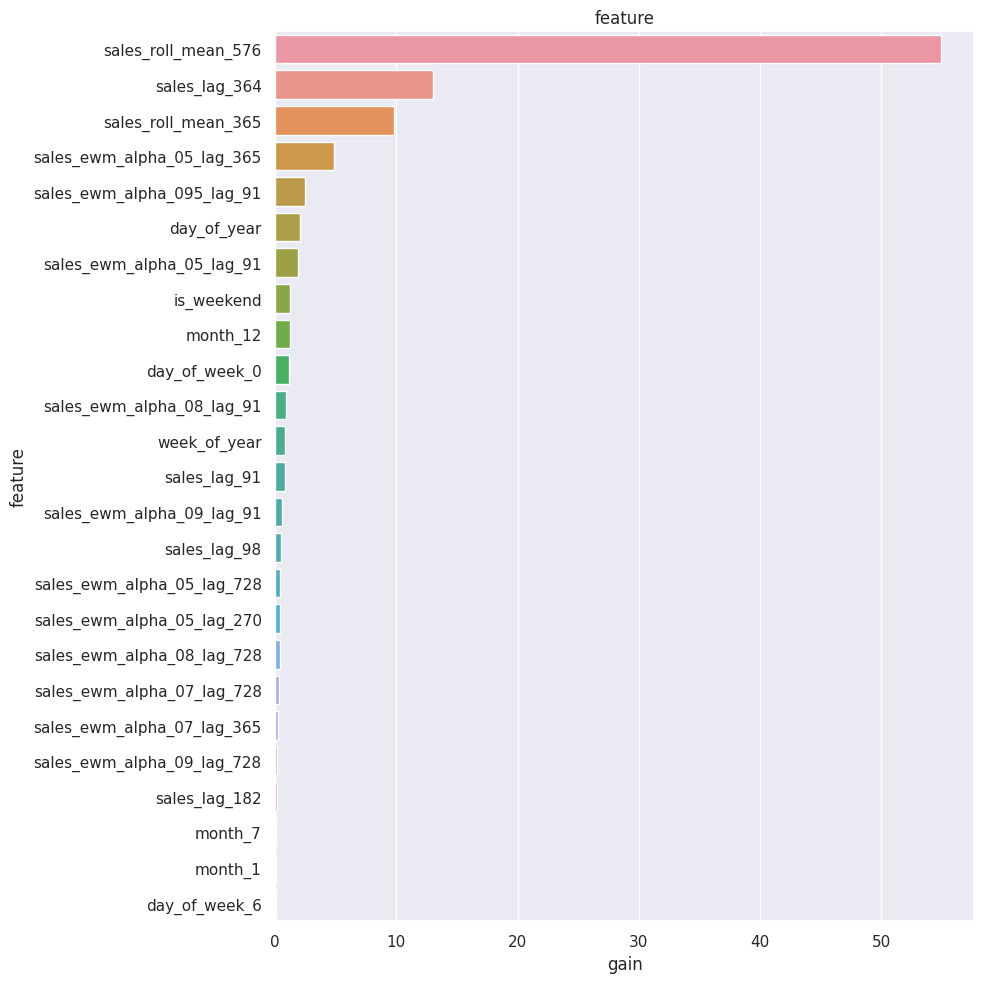

,feature,split,gain
17,sales_roll_mean_576,928,54.901991
13,sales_lag_364,1241,13.053647
16,sales_roll_mean_365,589,9.841412
60,sales_ewm_alpha_05_lag_365,368,4.878837
18,sales_ewm_alpha_095_lag_91,96,2.484236
...,...,...,...
111,item_39,0,0.000000
84,item_12,0,0.000000
66,store_4,0,0.000000
115,item_43,0,0.000000


In [ ]:
# Plot the feature importance
plot_lgb_importances(model, num=30, plot=True)

### Final model

Now, its time to train our model with the whole train dataset. Dont forget that we splited our train data into train and validation for evaluating our model. But, we will make our predictions on the test dataset. So, we need to train our model again with the whole train set and make prediction on the test set.

In [ ]:
# Crop the train data from the dataframe
train = df.loc[~df.sales.isna()]
y_train = train['sales']
X_train = train[cols]

In [ ]:
# Crop the test data from the dataframe
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [ ]:
# Final model parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'nthread': -1,
              "num_boost_round": 1000}

In [ ]:
# Final model and dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=lgb_params['num_boost_round'])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.560475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15034
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 142
[LightGBM] [Info] Start training from score 3.820443


In [ ]:
# Make predictions on the test dataset
test_preds = final_model.predict(X_test, num_iteration=1000)
test_preds

array([2.64673824, 2.75498749, 2.73423485, ..., 4.37607754, 4.42098521,
       4.46788247])

## Submission File

In [ ]:
# Creating submission file
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds) # return the predictions into non-log format

In [ ]:
# Turn the id type into integer
submission_df['id'] = submission_df['id'].astype(int)

In [ ]:
# Check the submission file
submission_df.head()

,id,sales
0,0,13.107947
1,1,14.720844
2,2,14.397957
3,3,14.153904
4,4,16.494148


In [ ]:
# Export the results into CSV file
submission_df.to_csv("submission_demand.csv", index=False)